# Basic neuronal activity analyzer notebook

This notebook demonstrates how to use the [neuronal activity analyzer library](https://github.com/Moschn/neuronal-activity-analyzer) in a Jupyter Notebook. 

Mathias Aebersold, 2017-10-24

## Environment

In [1]:
import analyzer
import os
from analyzer.normalize import normalize
from analyzer.correlation import correlate_activities
from matplotlib import pyplot
import numpy as np
from PIL import Image
%matplotlib inline

## 1. Load video and set analysis parameters

### 1.1 Load video

In [2]:
video_path = './Diode1/DIV14-Area2-GCaMP6s-Movie.tif'
loader = analyzer.open_video(video_path)

### 1.2 Set parameters
These are the configuration parameters and the possible values:
```python
default_config = {
    'segmentation_source': 'mean',                 # name of implementation: 'first_frame', 'mean', 'variance'
    'gauss_radius': 2.,                            # float: sigma for gauss filter in pixels
    'threshold': 'li',                             # float from 0 to 1 or name of algorithm: 'otsu', 'li', 'yen'
    'threshold_applicator': 'dynamicthreshold',    # name of implementation: 'dynamicthreshold', 'hardthreshold'
    'segmentation_algorithm': 'watershed',         # name of implementation: 'label', 'watershed', 'randomwalker'
    'integrater': 'mean',                          # name of implementation: 'mean'
    'spike_detection_algorithm': 'wdm',            # name of implementation: 'wdm', 'ntimesstd'
    'min_spike_width': 0.3,                        # for 'wdm': float [s]
    'max_spike_width': 4,                          #            float [s]
    'nSD_n': 3.,                                   # for 'ntimesstd': float, threshold value in std 
    'correlation_max_shift': 5.,                   #            float [s]
}
```

In [3]:
config = analyzer.util.load_config('config.py') 
config

config.py not found, using default


{'correlation_max_shift': 5.0,
 'gauss_radius': 2.0,
 'integrater': 'mean',
 'max_spike_width': 4,
 'min_spike_width': 0.3,
 'nSD_n': 3.0,
 'segmentation_algorithm': 'watershed',
 'segmentation_source': 'mean',
 'spike_detection_algorithm': 'wdm',
 'threshold': 'li',
 'threshold_applicator': 'dynamicthreshold'}

## 2 Segmentation

### 2.1 Automatic segmentation using 'Otsu' threshold

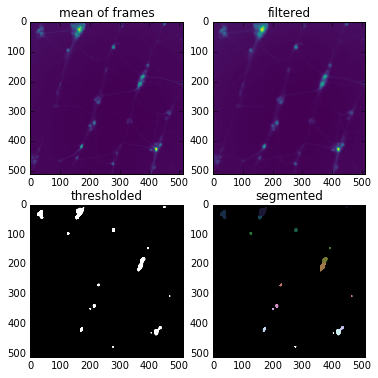

In [4]:
config['threshold']='otsu'
segmentated = analyzer.segment(loader, config)
fig, axarr = pyplot.subplots(2,2, figsize=(6,6))
axarr[0][0].imshow(segmentated['source'], cmap='viridis')
_ = axarr[0][0].set_title('mean of frames')
axarr[0][1].imshow(segmentated['filtered'], cmap='viridis')
_ = axarr[0][1].set_title('filtered')
axarr[1][0].imshow(segmentated['thresholded'], cmap='gray')
_ = axarr[1][0].set_title('thresholded')
axarr[1][1].imshow(segmentated['segmented'], cmap='cubehelix')
_ = axarr[1][1].set_title('segmented')


### 2.2 Manual threshold value

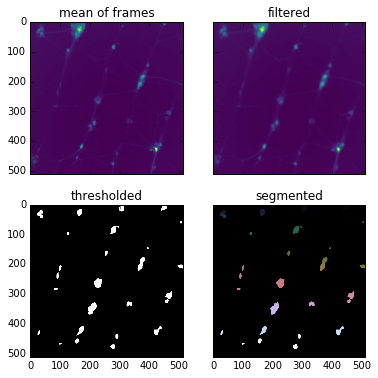

In [5]:
config['threshold'] = 0.05
segmentated = analyzer.segment(loader, config)
fig, axarr = pyplot.subplots(2,2, sharex=True, sharey=True, figsize=(6,6))
axarr[0][0].imshow(segmentated['source'], cmap='viridis')
_ = axarr[0][0].set_title('mean of frames')
axarr[0][1].imshow(segmentated['filtered'], cmap='viridis')
_ = axarr[0][1].set_title('filtered')
axarr[1][0].imshow(segmentated['thresholded'], cmap='gray')
_ = axarr[1][0].set_title('thresholded')
axarr[1][1].imshow(segmentated['segmented'], cmap='cubehelix')
_ = axarr[1][1].set_title('segmented')

## 3 Spike sorting

### 3.1 Extract fluorescence intensity traces for all ROIs

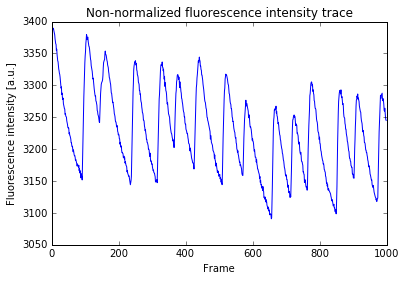

In [6]:
rois =  segmentated['segmented']
fluorescence_traces = analyzer.calculate_activities(loader, rois, config) 
_ = pyplot.plot(fluorescence_traces[0][:])
_ = pyplot.title('Non-normalized fluorescence intensity trace')
_ = pyplot.xlabel('Frame')
_ = pyplot.ylabel('Fluorescence intensity [a.u.]')

### 3.2 Normalize fluorescence intensity traces for all ROIs

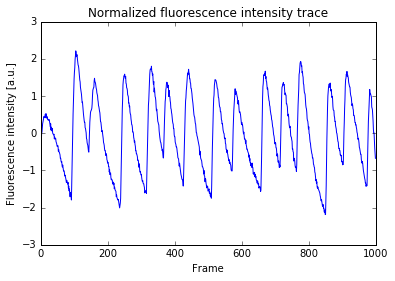

In [7]:
normalized_fluorescence_traces = normalize(fluorescence_traces)
_ = pyplot.plot(normalized_fluorescence_traces[0][:])
_ = pyplot.title('Normalized fluorescence intensity trace')
_ = pyplot.xlabel('Frame')
_ = pyplot.ylabel('Fluorescence intensity [a.u.]')

### 3.3 Detect spikes

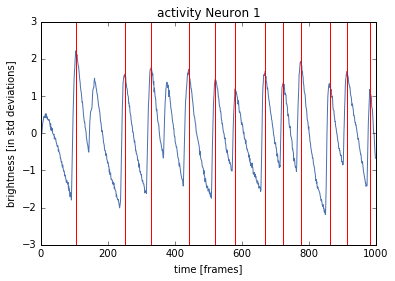

In [8]:
spikes = analyzer.detect_spikes(normalized_fluorescence_traces, config, loader.exposure_time)
neuron = 1
analyzer.plot.plot_spikes(normalized_fluorescence_traces[neuron-1], spikes[neuron-1])
_ = pyplot.title('activity Neuron {}'.format(neuron))

## 4 Correlation

In [9]:
correlation = correlate_activities(normalized_fluorescence_traces, config, loader.exposure_time)

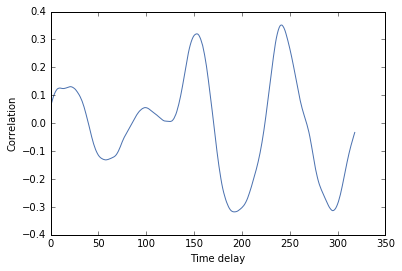

In [10]:
neuron1 = 1
neuron2 = 2
fig = analyzer.plot.plot_correlation_details(correlation[neuron1-1][neuron2-1])

## 5 Save results

In [11]:
video_name = video_path.split('/')[-1]
analysis_folder = './Diode1/analysis3/'
analyzer.save_results(rois, segmentated['source'], loader.pixel_per_um, loader.exposure_time,
                          normalized_fluorescence_traces, spikes, 1, correlation,
                          video_name, analysis_folder)

No seperate imagefile with background/foreground found
Only basic plot of ROIs will be generated!


D:\PhD\Programs\git\neuronal-activity-analyzer\analyzer\plot.py:172: RuntimeWarning: invalid value encountered in true_divide
  img_norm = (img - numpy.min(img))/max_dif * 2**8
